In [1]:
%store -r new_df
%store -r target

no stored variable or alias new_df
no stored variable or alias target


In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import catboost as cb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
from imblearn.combine import SMOTEENN
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
from imblearn.combine import SMOTETomek
from collections import Counter
from imblearn.ensemble import BalanceCascade 
from costcla.metrics import binary_classification_metrics
from sklearn.pipeline import make_pipeline
from skrebate import ReliefF
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import NearMiss 
from imblearn.ensemble import EasyEnsemble
from imblearn.ensemble import BalancedBaggingClassifier 
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.over_sampling import ADASYN 
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import     OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import MDS
from skrebate import MultiSURFstar
from sklearn.metrics import hamming_loss
from sklearn.model_selection import GridSearchCV
from costcla.metrics import savings_score, cost_loss
from boruta import BorutaPy
import shap
from skrebate.turf import TuRF
from sklearn.feature_selection import RFE
import numpy as np
from numpy.core.umath_tests import inner1d
from sklearn.ensemble import AdaBoostClassifier

ImportError: cannot import name 'BalanceCascade' from 'imblearn.ensemble' (/p_3_10/lib/python3.10/site-packages/imblearn/ensemble/__init__.py)

In [3]:
std=StandardScaler()
new_df.loc[:]=std.fit_transform(new_df.loc[:])

print(new_df.shape,target.shape)
print('base:',len(target[target['ny']==0])/1526)
print('E2K:',len(target[target['E2K']==0])/1526)
print('E2H:',len(target[target['E2H']==0])/1526)
print('E2S:',len(target[target['E2S']==0])/1526)
print('E2O:',len(target[target['E2O']==0])/1526)
print('E2E:',len(target[target['E2E']==0])/1526)
print('E2R:',len(target[target['E2R']==0])/1526)

(1526, 121) (1526, 7)
base: 0.6972477064220184
E2K: 0.973132372214941
E2H: 0.8446920052424639
E2S: 0.7896461336828309
E2O: 0.9587155963302753
E2E: 0.935124508519004
E2R: 0.9134993446920052


In [4]:
# -*- coding:utf-8 -*-



class AdaCostClassifier(AdaBoostClassifier):
    def _boost_real(self, iboost, X, y, sample_weight, random_state):
        """Implement a single boost using the SAMME.R real algorithm."""
        estimator = self._make_estimator(random_state=random_state)
        estimator.fit(X, y, sample_weight=sample_weight)

        y_predict_proba = estimator.predict_proba(X)

        if iboost == 0:
            self.classes_ = getattr(estimator, 'classes_', None)
            self.n_classes_ = len(self.classes_)

        y_predict = self.classes_.take(np.argmax(y_predict_proba, axis=1),
                                       axis=0)

        incorrect = y_predict != y

        estimator_error = np.mean(
            np.average(incorrect, weights=sample_weight, axis=0))

        if estimator_error <= 0:
            return sample_weight, 1., 0.

        n_classes = self.n_classes_
        classes = self.classes_
        y_codes = np.array([-1. / (n_classes - 1), 1.])
        y_coding = y_codes.take(classes == y[:, np.newaxis])

        proba = y_predict_proba  # alias for readability
        proba[proba < np.finfo(proba.dtype).eps] = np.finfo(proba.dtype).eps

        estimator_weight = (-1. * self.learning_rate
                                * (((n_classes - 1.) / n_classes) *
                                   inner1d(y_coding, np.log(y_predict_proba))))

        # 样本更新的公式，只需要改写这里
        if not iboost == self.n_estimators - 1:
            sample_weight *= np.exp(estimator_weight *
                                    ((sample_weight > 0) |
                                     (estimator_weight < 0)) *
                                    self._beta(y, y_predict))  # 在原来的基础上乘以self._beta(y, y_predict)，即代价调整函数
        return sample_weight, 1., estimator_error


    #  新定义的代价调整函数
    def _beta(self, y, y_hat):
        res = []
        for i in zip(y, y_hat):
            if i[0] == i[1]:
                res.append(1)   # 正确分类，系数保持不变，按原来的比例减少
            elif i[0] == 1 and i[1] == 0:
                res.append(1.8) 
            elif i[0] == 0 and i[1] == 1:
                res.append(1)  # 将负例误判为正例，代价不变，按原来的比例增加
            else:
                print(i[0], i[1])

        return np.array(res)

In [5]:
def modeling(df):
    n=min(45,df.shape[1])
    models={
            "CAT": {"f": cb.CatBoostClassifier(iterations=500,learning_rate=0.01,depth=6,od_wait=100,verbose=False,l2_leaf_reg=0.1)},
            "GBDT": {"f": GradientBoostingClassifier()},
            "ADA": {"f": AdaBoostClassifier(n_estimators=70)},
            "ADAC":{"f":AdaCostClassifier(n_estimators=70)},
            "EXTRA":{"f":ExtraTreesClassifier(n_estimators=100,max_depth=18,max_features=n)},
            "BBC": {"f":  BalancedBaggingClassifier(base_estimator=AdaCostClassifier(n_estimators=70),sampling_strategy="not majority")},       
            "EEC": {"f": EasyEnsembleClassifier(base_estimator=AdaCostClassifier(n_estimators=70),sampling_strategy="not majority")},   
            "RUS_ADAC":{"f":RUSBoostClassifier(base_estimator=AdaCostClassifier(n_estimators=70),sampling_strategy="not majority")},
            "RUS_EX":{"f":RUSBoostClassifier(base_estimator=ExtraTreesClassifier(n_estimators=100,max_depth=18,max_features=n),sampling_strategy="not majority")}
           }
    return models




# cat=cb.CatBoostClassifier(iterations=500,learning_rate=0.01,depth=6,od_wait=100,verbose=False,l2_leaf_reg=0.1)
# gb=GradientBoostingClassifier()
# ada=AdaBoostClassifier(n_estimators=70)

In [6]:
y=target['ny']

In [7]:
def entropy(df=new_df):
    try:
        s=np.linalgsvd(df.values,compute_uv=False)
    except:
        s=np.linalg.svd(df,compute_uv=False)
    mat_en=np.log2(np.inner(s,np.log2(1+s)))
    return mat_en

def train(models=modeling(new_df),t=y,contamination=0.3,df=new_df,show_baseline=False,random_state=None):
#    global y_test,y_train entropy

    global cp_df
    models=modeling(df)
    clf=IsolationForest(n_estimators=100,max_samples='auto',contamination=contamination,max_features=1.0,
                   random_state=27)
    df=pd.DataFrame(df)
    clf.fit(df)
    cp_df=df.copy()

    cp_df['anomaly']=clf.predict(df)
    
    try:
        x_train,x_test,y_train,y_test=train_test_split(cp_df,t,test_size=0.2,stratify=t,random_state=random_state)
    except:
        x_train,x_test,y_train,y_test=train_test_split(cp_df,t,test_size=0.2,random_state=random_state)

#     print(y_train.shape)
    for model in models.keys():
        try:
            models[model]['f'].fit(x_train,y_train)
            models[model]["c_train"]=models[model]['f'].predict(x_train)
            models[model]["c"]=models[model]['f'].predict(x_test)
            models[model]["p"] = models[model]['f'].predict_proba(x_test)
        except:
            models[model]['f'].fit(x_train.values,y_train.values)
            models[model]["c_train"]=models[model]['f'].predict(x_train.values)
            models[model]["c"]=models[model]['f'].predict(x_test.values)
            models[model]["p"] = models[model]['f'].predict_proba(x_test.values)
            
            
    measures = {"f1": f1_score, "pre": precision_score, "rec": recall_score, "acc": accuracy_score,"loss":hamming_loss}
    results = pd.DataFrame(columns=measures.keys())
    
    print('---------------Training-------------------')
    for model in models.keys():
        results.loc[model] = [measures[measure](y_train, models[model]["c_train"]) for measure in measures.keys()]
    print(results)
    
    print('---------------Testing-------------------')
    for model in models.keys():
        results.loc[model] = [measures[measure](y_test, models[model]["c"]) for measure in measures.keys()]
    print(results)

    def acc():
        lst=[]
        values=[]
        for col in target.columns:
            count=0
            for i in target[target[col]==1].index:
                if pred[i]==-1:
                    count+=1
            lst.append(count/len(target[target[col]==1]))
            values.append(len(target[target[col]==1]))
        x=pd.DataFrame([target.columns,values,lst])
        print(x)
    
    if show_baseline:
        acc()

In [26]:
train()

---------------Training-------------------
                f1       pre       rec       acc      loss
CAT       0.276423  1.000000  0.160377  0.927049  0.072951
GBDT      0.496454  1.000000  0.330189  0.941803  0.058197
ADA       0.181818  0.733333  0.103774  0.918852  0.081148
ADAC      0.402778  0.318681  0.547170  0.859016  0.140984
EXTRA     0.995261  1.000000  0.990566  0.999180  0.000820
BBC       0.338843  0.301471  0.386792  0.868852  0.131148
EEC       0.402778  0.318681  0.547170  0.859016  0.140984
RUS_ADAC  0.434783  0.403226  0.471698  0.893443  0.106557
RUS_EX    1.000000  1.000000  1.000000  1.000000  0.000000
---------------Testing-------------------
                f1       pre       rec       acc      loss
CAT       0.000000  0.000000  0.000000  0.908497  0.091503
GBDT      0.000000  0.000000  0.000000  0.885621  0.114379
ADA       0.060606  0.142857  0.038462  0.898693  0.101307
ADAC      0.192771  0.140351  0.307692  0.781046  0.218954
EXTRA     0.000000  0.000000  

In [8]:
sm = SMOTEENN()
X_enn, y_enn = sm.fit_sample(new_df, y)

sm = SMOTETomek()
X_tomek, y_tomek = sm.fit_sample(new_df, y)

print(entropy())
print(entropy(X_enn))
print(entropy(X_tomek))

14.12678249413093
13.51004312602526
14.354648877308659


In [28]:
print(pd.Series(y_enn).value_counts())
len(X_enn),len(X_tomek)


1    1377
0     944
dtype: int64


(2321, 2786)

In [29]:
rf = ExtraTreesClassifier()
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1,max_iter=200)
feat_selector.fit(X_enn, y_enn.ravel())
feat_selector.ranking_
X_filtered = feat_selector.transform(X_enn)

col_lst=[]
for i,col in enumerate(new_df.columns):
    if feat_selector.support_[i]:
        col_lst.append(col)


Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	121
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	121
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	121
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	121
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	121
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	121
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	121
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	27
Tentative: 	24
Rejected: 	70
Iteration: 	9 / 200
Confirmed: 	27
Tentative: 	24
Rejected: 	70
Iteration: 	10 / 200
Confirmed: 	27
Tentative: 	24
Rejected: 	70
Iteration: 	11 / 200
Confirmed: 	27
Tentative: 	24
Rejected: 	70
Iteration: 	12 / 200
Confirmed: 	29
Tentative: 	22
Rejected: 	70
Iteration: 	13 / 200
Confirmed: 	29
Tentative: 	22
Rejected: 	70
Iteration: 	14 / 200
Confirmed: 	29
Tentative: 	22
Rejected: 	70
Iteration: 	15 / 200
Confirmed: 	29
Tentative: 	22
Rejected: 	70
Iteration: 	16 / 200
Confirmed: 	32
Tenta

Iteration: 	128 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	129 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	130 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	131 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	132 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	133 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	134 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	135 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	136 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	137 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	138 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	139 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	140 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	141 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	142 / 200
Confirmed: 	41
Tentative: 	5
Rejected: 	75
Iteration: 	143 / 200
Con

In [30]:

train(t=y_enn,df=X_enn,random_state=0)

---------------Training-------------------
                f1       pre       rec       acc      loss
CAT       0.976766  1.000000  0.954587  0.973060  0.026940
GBDT      0.975926  0.995279  0.957312  0.971983  0.028017
ADA       0.947661  0.966919  0.929155  0.939116  0.060884
ADAC      0.809121  0.679852  0.999092  0.720366  0.279634
EXTRA     1.000000  1.000000  1.000000  1.000000  0.000000
BBC       0.834615  0.723816  0.985468  0.768319  0.231681
EEC       0.809121  0.679852  0.999092  0.720366  0.279634
RUS_ADAC  0.837529  0.721893  0.997275  0.770474  0.229526
RUS_EX    1.000000  1.000000  1.000000  1.000000  0.000000
---------------Testing-------------------
                f1       pre       rec       acc      loss
CAT       0.960748  0.992278  0.931159  0.954839  0.045161
GBDT      0.946396  0.966038  0.927536  0.937634  0.062366
ADA       0.933573  0.925267  0.942029  0.920430  0.079570
ADAC      0.786647  0.656174  0.981884  0.683871  0.316129
EXTRA     0.982014  0.975000  

In [31]:
train(t=y_enn,df=X_filtered,random_state=0)

---------------Training-------------------
                f1       pre       rec       acc      loss
CAT       0.978684  0.999054  0.959128  0.975216  0.024784
GBDT      0.973574  0.994318  0.953678  0.969289  0.030711
ADA       0.945908  0.963277  0.929155  0.936961  0.063039
ADAC      0.802771  0.670524  1.000000  0.708513  0.291487
EXTRA     1.000000  1.000000  1.000000  1.000000  0.000000
BBC       0.820974  0.698534  0.995459  0.742457  0.257543
EEC       0.802771  0.670524  1.000000  0.708513  0.291487
RUS_ADAC  0.827560  0.706752  0.998183  0.753233  0.246767
RUS_EX    1.000000  1.000000  1.000000  1.000000  0.000000
---------------Testing-------------------
                f1       pre       rec       acc      loss
CAT       0.959259  0.981061  0.938406  0.952688  0.047312
GBDT      0.948148  0.969697  0.927536  0.939785  0.060215
ADA       0.921676  0.926740  0.916667  0.907527  0.092473
ADAC      0.787172  0.658537  0.978261  0.686022  0.313978
EXTRA     0.974820  0.967857  

In [32]:
clf=ReliefF(n_features_to_select=30, n_neighbors=50)
X_clf=clf.fit(X_enn,y_enn).transform(X_enn)

train(t=y_enn,df=X_clf,random_state=666)

---------------Training-------------------
                f1       pre       rec       acc      loss
CAT       0.970547  1.000000  0.942779  0.966056  0.033944
GBDT      0.966900  0.993295  0.941871  0.961746  0.038254
ADA       0.935970  0.971652  0.902816  0.926724  0.073276
ADAC      0.778761  0.638051  0.999092  0.663254  0.336746
EXTRA     1.000000  1.000000  1.000000  1.000000  0.000000
BBC       0.792058  0.657280  0.996367  0.689655  0.310345
EEC       0.778761  0.638051  0.999092  0.663254  0.336746
RUS_ADAC  0.805128  0.674647  0.998183  0.713362  0.286638
RUS_EX    1.000000  1.000000  1.000000  1.000000  0.000000
---------------Testing-------------------
                f1       pre       rec       acc      loss
CAT       0.958801  0.992248  0.927536  0.952688  0.047312
GBDT      0.964880  0.984906  0.945652  0.959140  0.040860
ADA       0.929368  0.954198  0.905797  0.918280  0.081720
ADAC      0.770745  0.629885  0.992754  0.649462  0.350538
EXTRA     0.980180  0.974910  

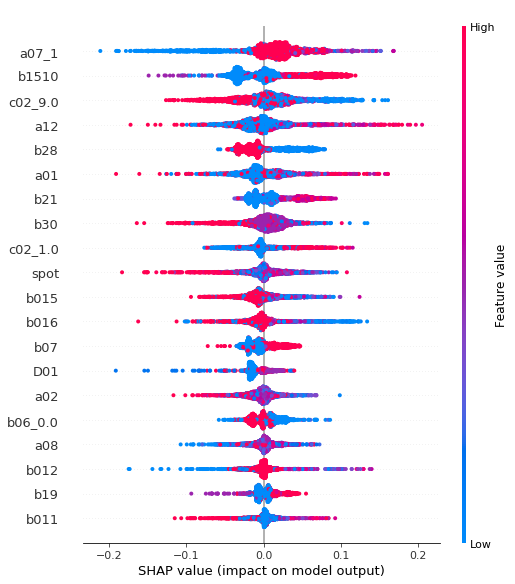

---------------Training-------------------
                f1       pre       rec       acc      loss
CAT       0.968677  0.998073  0.940963  0.963901  0.036099
GBDT      0.963101  0.991346  0.936421  0.957435  0.042565
ADA       0.939635  0.969112  0.911898  0.930496  0.069504
ADAC      0.775625  0.633487  1.000000  0.656789  0.343211
EXTRA     1.000000  1.000000  1.000000  1.000000  0.000000
BBC       0.802641  0.673231  0.993642  0.710129  0.289871
EEC       0.775625  0.633487  1.000000  0.656789  0.343211
RUS_ADAC  0.808840  0.680297  0.997275  0.720366  0.279634
RUS_EX    1.000000  1.000000  1.000000  1.000000  0.000000
---------------Testing-------------------
                f1       pre       rec       acc      loss
CAT       0.962825  0.988550  0.938406  0.956989  0.043011
GBDT      0.962963  0.984848  0.942029  0.956989  0.043011
ADA       0.944853  0.958955  0.931159  0.935484  0.064516
ADAC      0.774194  0.631579  1.000000  0.653763  0.346237
EXTRA     0.971326  0.960993  

In [33]:
ex=ExtraTreesClassifier()
ex.fit(X_enn,y_enn)
explainer = shap.TreeExplainer(ex)
X_en=pd.DataFrame(X_enn,columns=new_df.columns)
shap_values = explainer.shap_values(X_en)
shap.summary_plot(shap_values[1], X_en)

X_shap_ny=X_en[['c02_9.0','b19','a07_2','b12','b015','spot','b011','b152','c02_1.0','b30','b154','a10','b014','b016','b176'
            ,'a02','a07_10','b27_0.0','a12','a05']]
X_shap_E2S=X_en[['c02_9.0','a01','b014','a12','b158','b12','b016','a07_2','b015','b159','b27_0.0','b28','a07_1','b1510',
                 'b176','b157','spot','b19','b011','b151','a08','b11','b012','b14_0.0','a02','D01']]
X_shap_E2H=X_en[['c02_9.0','b16','a08','b011','b015','b014','spot','b016','a07_1','a02','a12','a07_2','b30','a05','a10',
                'b05','a01','b14_0.0','b1510','D01','b19','c02_3.0','c02_1.0','b32','b13','b18_0.0','b151']]
train(t=y_enn,df=X_shap_E2H,random_state=666)

In [34]:
fs=RFE(ReliefF(), n_features_to_select=30, step = 0.4)
X_turf=fs.fit(X_enn,y_enn).transform(X_enn)

train(t=y_enn,df=X_turf,random_state=666)

---------------Training-------------------
                f1       pre       rec       acc      loss
CAT       0.920709  0.946309  0.896458  0.908405  0.091595
GBDT      0.932296  0.939171  0.925522  0.920259  0.079741
ADA       0.887656  0.903955  0.871935  0.869073  0.130927
ADAC      0.770578  0.627138  0.999092  0.647091  0.352909
EXTRA     0.993234  0.986559  1.000000  0.991918  0.008082
BBC       0.778528  0.639603  0.994550  0.664332  0.335668
EEC       0.770578  0.627138  0.999092  0.647091  0.352909
RUS_ADAC  0.797386  0.664247  0.997275  0.699353  0.300647
RUS_EX    1.000000  1.000000  1.000000  1.000000  0.000000
---------------Testing-------------------
                f1       pre       rec       acc      loss
CAT       0.917431  0.929368  0.905797  0.903226  0.096774
GBDT      0.926740  0.937037  0.916667  0.913978  0.086022
ADA       0.890130  0.915709  0.865942  0.873118  0.126882
ADAC      0.770950  0.627273  1.000000  0.647312  0.352688
EXTRA     0.955595  0.937282  

In [35]:
im = Isomap(n_components=30)
X_im=im.fit_transform(X_enn)
train(t=y_enn,df=X_im,random_state=666)

---------------Training-------------------
                f1       pre       rec       acc      loss
CAT       0.973766  0.953833  0.994550  0.968211  0.031789
GBDT      0.970393  0.944923  0.997275  0.963901  0.036099
ADA       0.925910  0.894915  0.959128  0.908944  0.091056
ADAC      0.854920  0.747619  0.998183  0.799030  0.200970
EXTRA     1.000000  1.000000  1.000000  1.000000  0.000000
BBC       0.844735  0.732179  0.998183  0.782328  0.217672
EEC       0.854920  0.747619  0.998183  0.799030  0.200970
RUS_ADAC  0.882471  0.790230  0.999092  0.842134  0.157866
RUS_EX    1.000000  1.000000  1.000000  1.000000  0.000000
---------------Testing-------------------
                f1       pre       rec       acc      loss
CAT       0.947917  0.910000  0.989130  0.935484  0.064516
GBDT      0.936317  0.891803  0.985507  0.920430  0.079570
ADA       0.901361  0.849359  0.960145  0.875269  0.124731
ADAC      0.843077  0.732620  0.992754  0.780645  0.219355
EXTRA     0.961268  0.934932  

In [36]:
lle = LocallyLinearEmbedding(n_components=30)
X_lle=lle.fit_transform(X_enn)
train(t=y_enn,df=X_lle,random_state=666)

---------------Training-------------------
                f1       pre       rec       acc      loss
CAT       0.954971  0.937828  0.972752  0.945582  0.054418
GBDT      0.951253  0.954296  0.948229  0.942349  0.057651
ADA       0.931643  0.928700  0.934605  0.918642  0.081358
ADAC      0.877543  0.782361  0.999092  0.834591  0.165409
EXTRA     0.963165  0.964481  0.961853  0.956358  0.043642
BBC       0.885404  0.794372  1.000000  0.846444  0.153556
EEC       0.877543  0.782361  0.999092  0.834591  0.165409
RUS_ADAC  0.922497  0.856143  1.000000  0.900323  0.099677
RUS_EX    0.963165  0.964481  0.961853  0.956358  0.043642
---------------Testing-------------------
                f1       pre       rec       acc      loss
CAT       0.940767  0.906040  0.978261  0.926882  0.073118
GBDT      0.925267  0.909091  0.942029  0.909677  0.090323
ADA       0.893238  0.877622  0.909420  0.870968  0.129032
ADAC      0.852665  0.751381  0.985507  0.797849  0.202151
EXTRA     0.946429  0.933099  

In [37]:
mds = MDS(n_components=30)
X_mds=mds.fit_transform(X_enn)
train(t=y_enn,df=X_mds,random_state=666)


---------------Training-------------------
                f1       pre       rec       acc      loss
CAT       0.938176  0.895215  0.985468  0.922953  0.077047
GBDT      0.945743  0.919383  0.973660  0.933728  0.066272
ADA       0.843215  0.816327  0.871935  0.807651  0.192349
ADAC      0.816054  0.690566  0.997275  0.733297  0.266703
EXTRA     1.000000  1.000000  1.000000  1.000000  0.000000
BBC       0.802920  0.671141  0.999092  0.709052  0.290948
EEC       0.816054  0.690566  0.997275  0.733297  0.266703
RUS_ADAC  0.832702  0.713822  0.999092  0.761853  0.238147
RUS_EX    1.000000  1.000000  1.000000  1.000000  0.000000
---------------Testing-------------------
                f1       pre       rec       acc      loss
CAT       0.859060  0.800000  0.927536  0.819355  0.180645
GBDT      0.868056  0.833333  0.905797  0.836559  0.163441
ADA       0.811951  0.788396  0.836957  0.769892  0.230108
ADAC      0.783626  0.656863  0.971014  0.681720  0.318280
EXTRA     0.889667  0.861017  

In [38]:
transformer = MiniBatchSparsePCA(n_components=30,
             batch_size=50,normalize_components=True, random_state=0)
X_tf=transformer.fit_transform(X_enn)
train(t=y_enn,df=X_tf,random_state=666)

---------------Training-------------------
                f1       pre       rec       acc      loss
CAT       0.969054  0.944014  0.995459  0.962284  0.037716
GBDT      0.956291  0.930412  0.983651  0.946659  0.053341
ADA       0.870107  0.852659  0.888283  0.842672  0.157328
ADAC      0.819033  0.697066  0.992734  0.739763  0.260237
EXTRA     1.000000  1.000000  1.000000  1.000000  0.000000
BBC       0.814650  0.687266  1.000000  0.730065  0.269935
EEC       0.819033  0.697066  0.992734  0.739763  0.260237
RUS_ADAC  0.840779  0.725296  1.000000  0.775323  0.224677
RUS_EX    1.000000  1.000000  1.000000  1.000000  0.000000
---------------Testing-------------------
                f1       pre       rec       acc      loss
CAT       0.926746  0.874598  0.985507  0.907527  0.092473
GBDT      0.890388  0.832808  0.956522  0.860215  0.139785
ADA       0.820423  0.797945  0.844203  0.780645  0.219355
ADAC      0.795888  0.669136  0.981884  0.701075  0.298925
EXTRA     0.964789  0.938356  

In [39]:
embedding = SpectralEmbedding(n_components=30)
X_se=embedding.fit_transform(X_enn)
train(t=y_enn,df=X_se,random_state=666)

---------------Training-------------------
                f1       pre       rec       acc      loss
CAT       0.950805  0.913043  0.991826  0.939116  0.060884
GBDT      0.939749  0.898839  0.984559  0.925108  0.074892
ADA       0.883208  0.857877  0.910082  0.857220  0.142780
ADAC      0.822123  0.698413  0.999092  0.743534  0.256466
EXTRA     1.000000  1.000000  1.000000  1.000000  0.000000
BBC       0.819523  0.702335  0.983651  0.742996  0.257004
EEC       0.822123  0.698413  0.999092  0.743534  0.256466
RUS_ADAC  0.851838  0.741914  1.000000  0.793642  0.206358
RUS_EX    1.000000  1.000000  1.000000  1.000000  0.000000
---------------Testing-------------------
                f1       pre       rec       acc      loss
CAT       0.903010  0.838509  0.978261  0.875269  0.124731
GBDT      0.883333  0.817901  0.960145  0.849462  0.150538
ADA       0.842105  0.792332  0.898551  0.800000  0.200000
ADAC      0.794760  0.664234  0.989130  0.696774  0.303226
EXTRA     0.938918  0.905724  

In [38]:
from sklearn.cluster import KMeans
# tsne = TSNE(n_components=2, init='random', random_state=0)
# digits_proj = tsne.fit_transform(X_enn)

kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(X_enn)
res=kmeans.__dict__
# print (res['cluster_centers_'])

In [46]:
X_en['cls'].value_counts()

0    657
1    350
Name: cls, dtype: int64

In [45]:
X_en['cls']=X_en['cls'].replace(0,-1)
X_en['cls']=X_en['cls'].replace(1,0)
X_en['cls']=X_en['cls'].replace(-1,1)

In [39]:
X_en=pd.DataFrame(X_enn)
X_en['cls']=clusters

In [40]:
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj= tsne.fit_transform(X_en)

In [48]:
precision_score(y_enn, X_en['cls'], average='macro') 

0.6692454881495977

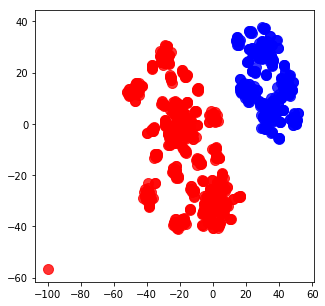

In [42]:
plt.figure(figsize=(5,5))
## python uses painter's algorithm by default: the later drawing one will coer the previous drawing


plt.scatter(digits_proj[X_en['cls']==1,0],digits_proj[X_en['cls']==1,1],label='E2H',color='r',alpha=0.8,s=100)
# plt.scatter(digits_proj[X_en['cls']==2,0],digits_proj[X_en['cls']==2,1],label='E2H',color='g',alpha=0.8,s=100)
plt.scatter(digits_proj[X_en['cls']==0,0],digits_proj[X_en['cls']==0,1],label='E2H',color='b',alpha=0.8,s=100)
# plt.scatter(digits_proj[X_en['cls']==3,0],digits_proj[X_en['cls']==3,1],label='E2H',color='y',alpha=0.8,s=100)

In [ ]:

labels = np.zeros_like(clusters)
for i in range(3):
    mask = (clusters == i)
    labels[mask] = mode(target['ny'][mask])[0]

In [16]:
# bc = BalanceCascade(random_state=42)
# X_res, y_res = bc.fit_sample(new_df, y)
# print('Resampled dataset shape {}'.format(Counter(y_res[0])))   
# X_res
# train(model,y_res,df=X_res)
# # bc = BalanceCascade(random_state=0,estimator=LogisticRegression(random_state=0),n_max_subset=6)

# # X_res, y_res= bc.fit_sample(new_df, y)
# # train(model,y_res,X_res)
extratree rocplot 每个binary relief

In [190]:
from sklearn.metrics import classification_report
from simulated_annealing.optimize import SimulatedAnneal
svc_params = {'C':np.logspace(-8, 10, 19, base=2),
              'fit_intercept':[True, False]
             }
sa = SimulatedAnneal(AdaBoostClassifier(n_estimators=70),svc_params= T=10.0, T_min=0.001, alpha=0.75,
                         verbose=True, max_iter=0.25, n_trans=5, max_runtime=300,
                         cv=3, scoring='f1_macro', refit=True)
sa.fit(X_enn, y_enn)

TypeError: __init__() missing 1 required positional argument: 'param_grid'

1    615
0    364
dtype: int64

---------------Training-------------------
            f1       pre       rec       acc      loss
ADAC  0.826196  0.703863  1.000000  0.735632  0.264368
BBC   0.831784  0.712012  1.000000  0.745849  0.254151
EEC   0.826196  0.703863  1.000000  0.735632  0.264368
RUS   0.842918  0.729569  0.997967  0.766284  0.233716
---------------Testing-------------------
            f1       pre       rec       acc      loss
ADAC  0.787671  0.680473  0.934959  0.683673  0.316327
BBC   0.791946  0.674286  0.959350  0.683673  0.316327
EEC   0.787671  0.680473  0.934959  0.683673  0.316327
RUS   0.821053  0.722222  0.951220  0.739796  0.260204


In [187]:



# nm1 = NearMiss(random_state=0, version=1)
# X_resampled_nm1, y_resampled_nm1 = nm1.fit_sample(new_df, y)
# train(t=y_resampled_nm1,df=X_resampled_nm1)


# ada = ADASYN(random_state=42)
# X_res, y_res = ada.fit_resample(new_df, y)
# train(t=y_res,df=X_res)


# iht = InstanceHardnessThreshold(random_state=27)
# X_res, y_res = iht.fit_resample(new_df, y)
# train(model,y_res,df=X_res)


# allknn = AllKNN()

# X_res, y_res = allknn.fit_resample(new_df, y)
# train(model,y_res,df=X_res)

---------------Training-------------------
acc 0.8404825737265416
recall 0.8391271843752921
precision 0.8636833179155103
f1 0.8375040041001987
---------------Testing----------------------
acc 0.7379679144385026
recall 0.737474262182567
precision 0.7460881934566146
f1 0.7355173906768653


---------------Training-------------------
acc 0.8028391167192429
recall 0.8136063813468324
precision 0.8054139112421321
f1 0.8019279842642093
---------------Testing----------------------
acc 0.6981132075471698
recall 0.6957478005865103
precision 0.6918103448275862
f1 0.6927536231884057


In [289]:

scaler = StandardScaler()
scaled_data=scaler.fit_transform(new_df.iloc[:])
tsne = TSNE(n_components = 2)
pca=PCA(n_components=2)
lle=LocallyLinearEmbedding(n_components=2)
iso = Isomap(n_components=2)

mds = MDS(n_components=2)
transformer = MiniBatchSparsePCA(n_components=5,
             batch_size=50,normalize_components=True, random_state=0)
embedding = SpectralEmbedding(n_components=2)
newData = transformer.fit_transform(scaled_data)

In [16]:

clf = make_pipeline(ReliefF(n_features_to_select=20, n_neighbors=50),
                    model)
# print(np.mean(cross_val_score(clf, new_df.values, target['ny'].values)))
train(clf,t=target['ny'],df=new_df.values)

TypeError: unhashable type: 'numpy.ndarray'

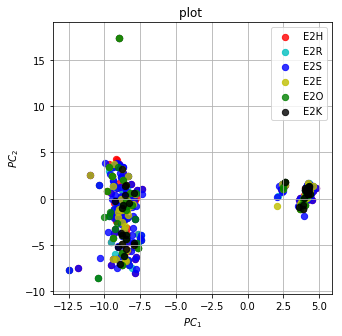

In [290]:
plt.figure(figsize=(5,5))
## python uses painter's algorithm by default: the later drawing one will coer the previous drawing


plt.scatter(newData[target['E2H']==1,0],newData[target['E2H']==1,1],label='E2H',color='r',alpha=0.8,s=40)
plt.scatter(newData[target['E2R']==1,0],newData[target['E2R']==1,1],label='E2R',color='c',alpha=0.8,s=40)
plt.scatter(newData[target['E2S']==1,0],newData[target['E2S']==1,1],label='E2S',color='b',alpha=0.8,s=40)
plt.scatter(newData[target['E2E']==1,0],newData[target['E2E']==1,1],label='E2E',color='y',alpha=0.8,s=40)
plt.scatter(newData[target['E2O']==1,0],newData[target['E2O']==1,1],label='E2O',color='g',alpha=0.8,s=40)
plt.scatter(newData[target['E2K']==1,0],newData[target['E2K']==1,1],label='E2K',color='k',alpha=0.8,s=40)
plt.legend()
plt.title('plot ')
plt.xlabel('$PC_{1}$')
plt.ylabel('$PC_{2}$')
ax=plt.gca()
ax.grid(True)

In [21]:
relief=MultiSURFstar(n_features_to_select=20)
relief.fit(new_df.values,target['ny'])
relief.transform(new_df)

TypeError: '(slice(None, None, None), array([ 25,  79,  74,  20, 112,  17,   3,  57,  13,  63,   4, 111, 117,
        58,  69,  49,  68,  65,  59,  71], dtype=int64))' is an invalid key

In [255]:
from costcla.models import BayesMinimumRiskClassifier
f_bmr = BayesMinimumRiskClassifier()
train(f_bmr,y_resampled,df=X_resampled)

(894, 121) (894, 121)


IndexError: too many indices for array

In [250]:
X_resampled.shape, y_resampled.shape

((894, 121), (894,))

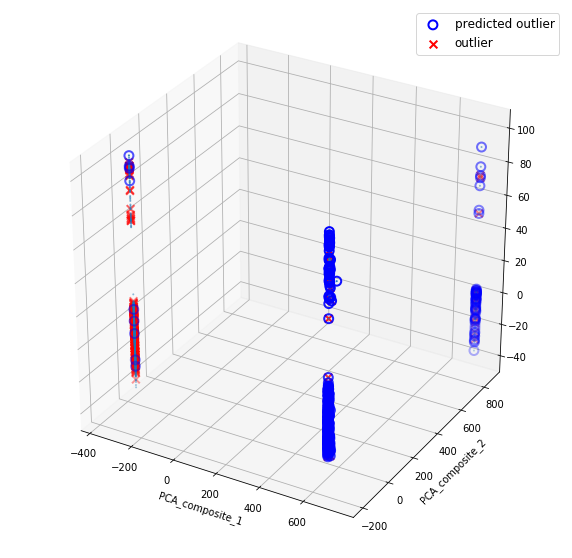

In [122]:
outliers=cp_df.loc[cp_df['anomaly']==-1]
outlier_index=list(outliers.index)
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()

GP = scaler.fit_transform(new_df)
GP_reduce = pca.fit_transform(new_df)
Xax=GP_reduce[:,0]
Yax=GP_reduce[:,1]
Zax=GP_reduce[:,2]
y1=target['ny']
fig = plt.figure(figsize=(10,10))
# ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("PCA_composite_1")
ax.set_ylabel("PCA_composite_2")
# Plot the reduced dimensionality data points
ax.scatter(GP_reduce[:, 0], GP_reduce[:, 1], zs=GP_reduce[:, 2], s=4, lw=0)

# Plot circles around the predicted outliers
ax.scatter(GP_reduce[pred==-1, 0], GP_reduce[pred==-1, 1], zs=GP_reduce[pred==-1, 2], 
           lw=2, facecolors="none", edgecolors="b", s=80, label="predicted outlier")

# Plot x's for the ground truth outliers
ax.scatter(GP_reduce[y1==1, 0], GP_reduce[y1==1, 1], zs=GP_reduce[y1==1, 2], 
           lw=2, s=60, marker="x", c="red", label="outlier")
ax.legend(prop={"size":12})

E2H


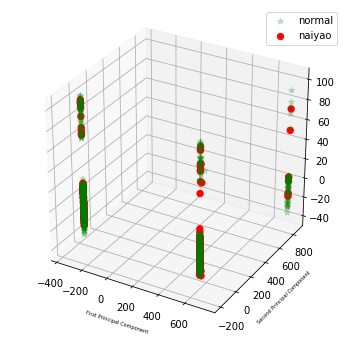

E2R


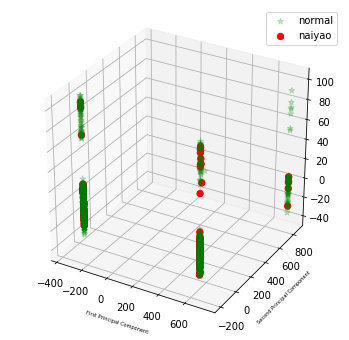

E2S


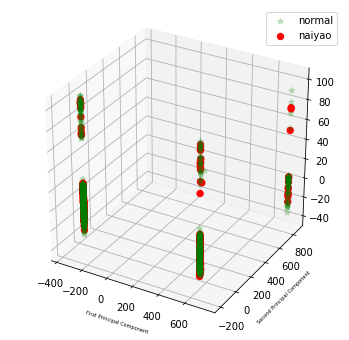

E2E


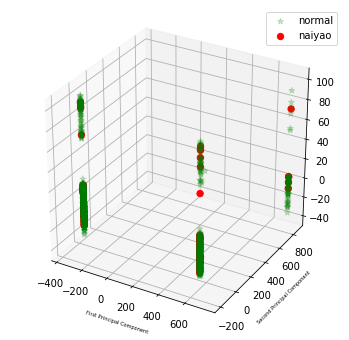

E2O


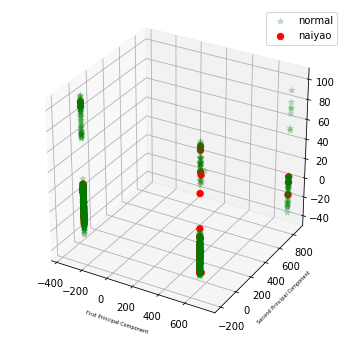

E2K


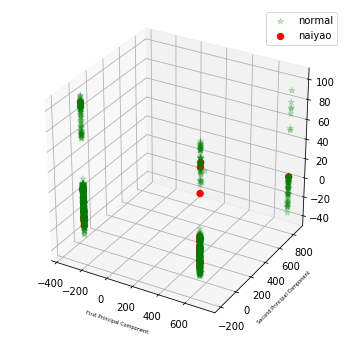

ny


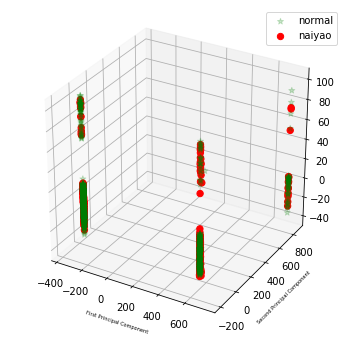

In [109]:


for col in target.columns:
    labels=target[col]
    cdict={0:'green',1:'red'}
    labl={0:'normal',1:'naiyao'}
    marker={0:'*',1:'o'}
    alpha={0:.2, 1:1}
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    fig.patch.set_facecolor('white')
    for l in np.unique(labels):
        ix=np.where(labels==l)
        ax.scatter(Xax[ix],Yax[ix],Zax[ix],c=cdict[l],s=40,
               label=labl[l],marker=marker[l],alpha=alpha[l])
    # for loop ends
    plt.xlabel("First Principal Component",fontsize=5)
    plt.ylabel("Second Principal Component",fontsize=5)
    plt.legend()
    print(col)
    plt.show()
# please check the scatter plot of the remaining component and you will understand the difference

<Figure size 360x360 with 0 Axes>

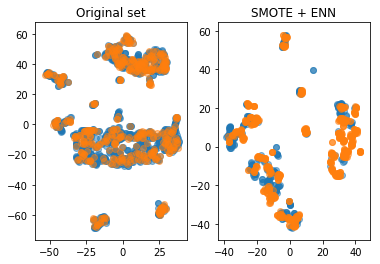

In [140]:

# Instanciate a PCA object for the sake of easy visualisation
tsne = TSNE(n_components=2)
X_vis = tsne.fit_transform(cp_df)

# Apply SMOTE + ENN

sm = SMOTEENN()
y=target['ny']
X_resampled, y_resampled = sm.fit_sample(cp_df, y)
X_res_vis = tsne.fit_transform(X_resampled)

# Two subplots, unpack the axes array immediately
plt.figure(figsize=(5,5))
f, (ax1, ax2) = plt.subplots(1, 2)

c0 = ax1.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1], label="normal",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1], label="resistent",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_resampled == 0, 0], X_res_vis[y_resampled == 0, 1],
            label="normal", alpha=0.5)
ax2.scatter(X_res_vis[y_resampled == 1, 0], X_res_vis[y_resampled == 1, 1],
            label="resistent", alpha=0.5)
ax2.set_title('SMOTE + ENN')

# make nice plotting
# for ax in (ax1, ax2):
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.get_xaxis().tick_bottom()
#     ax.get_yaxis().tick_left()
#     ax.spines['left'].set_position(('outward', 10))
#     ax.spines['bottom'].set_position(('outward', 10))
#     ax.set_xlim([-6, 8])
#     ax.set_ylim([-6, 6])

# f.legend((c0, c1), ('normal', 'resistent'), loc='lower center',
#          ncol=2, labelspacing=0.)
# plt.tight_layout(pad=3)

plt.show()
#nmi


In [44]:
def myfun(num):
     print(*num)

In [45]:
myfun([3,4,5])

3 4 5
